In [19]:
import pandas as pd
import numpy as np
import json
import time
import matplotlib.pyplot as plt

from datetime import datetime

filename = 'report_pilot_test.json'

In [20]:
with open(filename, encoding="utf-8") as f:
    target = f.read()

In [21]:
data = json.loads(target)
data['2']['data']['title']
data['2']['data']['content']
# start time
tstamp = data['2']['data']['key'][0]['timestamp']
print("Start Time: {}".format(datetime.fromtimestamp((tstamp)/1000.0)))

Start Time: 2022-06-29 13:58:28.674000


## Writing Length (Words Count)

In [25]:
content = data['2']['data']['content'].strip()
print(f"Note length: {len(content)} characters")
print(f"Note length: {len(content.split(' '))} words")

Note length: 592 characters
Note length: 103 words


## Writing Content

In [159]:
# text
print("Full note:")
print(content)
words_in_note = content.split(' ')

Full note:
It is very natural that academia is full of rejections, rejections from applications, conferences, jobs, collaboration requests... I should pratice my resilience towards it. Thinking about the experience of the interview, it was not necessary to stuck myself in the bad feeling of being rejected. Instead, focusing on what to do next is a better action. When I say this, I mean I am able to deal with rejections in the future. I am not afraid of rejections any more. Because I now understand that all these experiences are just here to help me to understand myself better and help me to grow.


In [154]:
import os
from pathlib import Path
pkl_file = Path(os.getcwd())# + '/../dict/picked-dict.pkl')
pkl_file = pkl_file.parents[0] / 'dict' / 'pickled-dict.pkl'
print(pkl_file)
unpickle_dict = pd.read_pickle(pkl_file)

/Users/royjara/dev/hci_lab/journal/dict/pickled-dict.pkl


In [186]:
# TODO: psycholinguistic analysis
# - import dict - import pickle lol
unpickle_dict[unpickle_dict['wordnet_ext'].notnull()]

# - same as js - find words present in dict

,Word,wordnet_ext,phrase_ext,rewrite,rewrite_position,popup_title,popup_feedback,Sidebar_feedback,color
81,anyone,[anybody],NaN,"[however, to be more realistic, however, ther...",after,All-or-Nothing,A common cognitive distortion that will extrap...,<h3>More About All-or-Nothing and Overgenerali...,#287db5
79,everyone,[everybody],NaN,"[however, to be more realistic, however, ther...",after,All-or-Nothing,A common cognitive distortion that will extrap...,<h3>More About All-or-Nothing and Overgenerali...,#287db5
0,depress,"[depressed, depression, gloomy, grim, blue...",NaN,NaN,NaN,NaN,This is a common sign that it is time to care ...,"<p>Are you feeling depressed, anxious, stresse...",#d3cd57
40,stress,"[stressful, stressed, overwhelmed, overwhel...","[difficulty breathing, hard of breathing, un...",NaN,NaN,NaN,This is a common sign that it is time to care ...,"<p>Are you feeling depressed, anxious, stresse...",#d3cd57
1,dyshphoria,"[unhappy, uneasy, dissatisfied, discomfort,...",NaN,NaN,NaN,NaN,This is a common sign that it is time to care ...,"<p>Are you feeling depressed, anxious, stresse...",#d3cd57
3,hopeless,"[desperate, despairing]","[no help, don't help]",NaN,NaN,NaN,This is a common sign that it is time to care ...,"<p>Are you feeling depressed, anxious, stresse...",#d3cd57
4,helpless,[incapacitated ],"[nobody help, no one help]",NaN,NaN,NaN,This is a common sign that it is time to care ...,"<p>Are you feeling depressed, anxious, stresse...",#d3cd57
5,worthlessness,"[worthless, despicable, ugly, vile, slimy,...","[what is the point, there is no point, worth...",NaN,NaN,NaN,This is a common sign that it is time to care ...,"<p>Are you feeling depressed, anxious, stresse...",#d3cd57
7,guilt,"[guilty, ashamed, embarrased]","[all my fault, blame on me]",NaN,NaN,NaN,This is a common sign that it is time to care ...,"<p>Are you feeling depressed, anxious, stresse...",#d3cd57
9,NaN,"[indifferent, apathetic]","[loss of interest, lost interest, lose inter...",NaN,NaN,NaN,This is a common sign that it is time to care ...,"<p>Are you feeling depressed, anxious, stresse...",#d3cd57


In [191]:
expanded = unpickle_dict.explode('wordnet_ext').reset_index(drop=True)
expanded = expanded.explode('phrase_ext').reset_index(drop=True)


In [192]:
expanded[expanded['wordnet_ext'].notnull()]

,Word,wordnet_ext,phrase_ext,rewrite,rewrite_position,popup_title,popup_feedback,Sidebar_feedback,color
35,anyone,anybody,NaN,"[however, to be more realistic, however, ther...",after,All-or-Nothing,A common cognitive distortion that will extrap...,<h3>More About All-or-Nothing and Overgenerali...,#287db5
54,everyone,everybody,NaN,"[however, to be more realistic, however, ther...",after,All-or-Nothing,A common cognitive distortion that will extrap...,<h3>More About All-or-Nothing and Overgenerali...,#287db5
86,depress,depressed,NaN,NaN,NaN,NaN,This is a common sign that it is time to care ...,"<p>Are you feeling depressed, anxious, stresse...",#d3cd57
87,depress,depression,NaN,NaN,NaN,NaN,This is a common sign that it is time to care ...,"<p>Are you feeling depressed, anxious, stresse...",#d3cd57
88,depress,gloomy,NaN,NaN,NaN,NaN,This is a common sign that it is time to care ...,"<p>Are you feeling depressed, anxious, stresse...",#d3cd57
...,...,...,...,...,...,...,...,...,...
384,distract,disquiet,hard to focus,NaN,NaN,NaN,This is a common sign that it is time to care ...,"<p>Are you feeling depressed, anxious, stresse...",#d3cd57
385,distract,disquiet,difficulty focusing,NaN,NaN,NaN,This is a common sign that it is time to care ...,"<p>Are you feeling depressed, anxious, stresse...",#d3cd57
386,distract,disquiet,can't pay attention,NaN,NaN,NaN,This is a common sign that it is time to care ...,"<p>Are you feeling depressed, anxious, stresse...",#d3cd57
387,distract,disquiet,hard to pay attention,NaN,NaN,NaN,This is a common sign that it is time to care ...,"<p>Are you feeling depressed, anxious, stresse...",#d3cd57


In [252]:
# unpickle_dict[ unpickle_dict['Word'].str.contains(words_in_note)  ]
dummy = ['anybody', 'all my faults', 'depress']
expanded[expanded['Word'].str.contains('|'.join(dummy), na=False) 
               | expanded['wordnet_ext'].str.contains('|'.join(dummy), na=False) 
               | expanded['phrase_ext'].str.contains('|'.join(dummy), na=False)].drop_duplicates(subset=['Word'])


,Word,wordnet_ext,phrase_ext,rewrite,rewrite_position,popup_title,popup_feedback,Sidebar_feedback,color
35,anyone,anybody,NaN,"[however, to be more realistic, however, ther...",after,All-or-Nothing,A common cognitive distortion that will extrap...,<h3>More About All-or-Nothing and Overgenerali...,#287db5
37,all my faults,NaN,all my fault,"[but I can't control, but I can't predict, b...",after,Blaming ourselves,A common distrotion that believes only one per...,NaN,#287db5
86,depress,depressed,NaN,NaN,NaN,NaN,This is a common sign that it is time to care ...,"<p>Are you feeling depressed, anxious, stresse...",#d3cd57


In [254]:
# TODO: join with categories to collect and graph








## Writing Behavior

JS EVT TIMESTAMP ==> TIME IN MILLISECONDS!


Analysis approach:
- no need to know actual time, just the difference between events
- plot the timestamps in the same order as indices.
- then bundle up all the rising ones as one session
- then analyze per session and combine!

<AxesSubplot:>

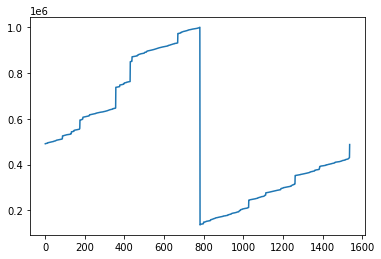

In [27]:
df = pd.DataFrame(data['2']['data']['key'])
df = df.drop([0])
df["timestamp"].plot()

In [28]:
df['timestamp_diff'] = df['timestamp'].diff()
df['session_id'] = df.apply(lambda row: 1 if row['timestamp_diff'] < 0 else 0, axis=1).cumsum()
df['pauses'] = df.apply(lambda row: 1 if row['timestamp_diff'] > 3000 else 0, axis=1)
df[['text', 'cursor', 'timestamp', 'session_id', 'timestamp_diff', 'pauses']][df['pauses']==1].head(3)

,text,cursor,timestamp,session_id,timestamp_diff,pauses
88,Rejections really hurt especially when you hav...,"{'line': 0, 'ch': 72, 'sticky': None}",525414.1,0,12412.8,1
133,Rejections really hurt especially when you hav...,"{'line': 0, 'ch': 115, 'sticky': None}",543434.4,0,8137.7,1
146,Rejections really hurt especially when you hav...,"{'line': 0, 'ch': 127, 'sticky': None}",549272.1,0,3720.5,1


In [50]:
# writing duration -- aggregate per session_id and add results
a = df.groupby('session_id')['timestamp'].max()
print(f"Writing duration {(a.sum()/1000)/60:.2f} minutes")


Writing duration 24.81 minutes


In [103]:
#plot dots of pauses overlay to timestamp timeline plot
pd.DataFrame(data['2']['data']['key'])

,timestamp,type,keycode,cursor,text,marks,placeholder,dismisses,accepts,l2dismisses
0,1.656536e+12,start,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4.910702e+05,type,8.0,"{'line': 0, 'ch': 0, 'sticky': None}",,[],,"[{'time': 1656536840023, 'suggestion': 'The lo...","[{'time': 1656536840023, 'suggestion': ''}, {'...","[{'word': 'can', 'offset': 0}, {'word': 'my', ..."
2,4.917219e+05,type,16.0,"{'line': 0, 'ch': 0, 'sticky': None}",,[],,"[{'time': 1656536840023, 'suggestion': 'The lo...","[{'time': 1656536840023, 'suggestion': ''}, {'...","[{'word': 'can', 'offset': 0}, {'word': 'my', ..."
3,4.917733e+05,type,82.0,"{'line': 0, 'ch': 0, 'sticky': None}",,[],,"[{'time': 1656536840023, 'suggestion': 'The lo...","[{'time': 1656536840023, 'suggestion': ''}, {'...","[{'word': 'can', 'offset': 0}, {'word': 'my', ..."
4,4.918464e+05,type,69.0,"{'line': 0, 'ch': 0, 'sticky': None}",,[],,"[{'time': 1656536840023, 'suggestion': 'The lo...","[{'time': 1656536840023, 'suggestion': ''}, {'...","[{'word': 'can', 'offset': 0}, {'word': 'my', ..."
...,...,...,...,...,...,...,...,...,...,...
1533,4.280956e+05,type,82.0,"{'line': 0, 'ch': 589, 'sticky': None}",It is very natural that academia is full of re...,[],,"[{'time': 1656649310681, 'suggestion': 'When I...","[{'time': 1656649310681, 'suggestion': ''}]",[]
1534,4.283679e+05,type,79.0,"{'line': 0, 'ch': 590, 'sticky': None}",It is very natural that academia is full of re...,[],,"[{'time': 1656649310681, 'suggestion': 'When I...","[{'time': 1656649310681, 'suggestion': ''}]",[]
1535,4.291500e+05,type,87.0,"{'line': 0, 'ch': 591, 'sticky': None}",It is very natural that academia is full of re...,[],,"[{'time': 1656649310681, 'suggestion': 'When I...","[{'time': 1656649310681, 'suggestion': ''}]",[]
1536,4.302697e+05,type,190.0,"{'line': 0, 'ch': 592, 'sticky': None}",It is very natural that academia is full of re...,[],,"[{'time': 1656649310681, 'suggestion': 'When I...","[{'time': 1656649310681, 'suggestion': ''}]",[]


In [29]:
# save to csv for further inspection.
df[['text', 'cursor', 'timestamp', 'session_id', 'timestamp_diff', 'pauses']][df['pauses']==1].to_csv('pauses.csv')

## Interactions with features

Simplify!
- separate into groups of interactions (columns): dismisses, accepts, l2dismisses
- but at the same time (before or after) 
- find unique for both 

Marks can be either placeholder (L1/L3) or highlights (L2)
dismisses are the L1/L3 dismisses
accepts are the L1/L3 accepts
l2dismisses are the 
placeholder only relevant if marks has placeholder

In [110]:
df_mouse = pd.DataFrame(data['2']['data']['mouse']).drop(0)
df_key = pd.DataFrame(data['2']['data']['key']).drop(0)

In [235]:
df_mouse_marks = df_mouse[df_mouse['marks'].map(lambda d: len(d)) > 0] \
                                           .drop(['placeholder','dismisses','accepts','l2dismisses','x','y'], axis=1) \
                                           .astype(str) \
                                           .drop_duplicates(subset=['marks'])
df_mouse_marks

,timestamp,type,marks
16,675767.8000000119,click,"[{'tag': 'placeholder', 'from': {'line': 0, 'c..."
19,687427.2000000477,click,"[{'tag': 'L2-highlight', 'from': {'line': 0, '..."
23,716725.1000000238,click,"[{'tag': 'L2-highlight', 'from': {'line': 0, '..."
28,768130.0,click,"[{'tag': 'L2-highlight', 'from': {'line': 0, '..."
69,939534.7000000477,click,"[{'tag': 'L2-highlight', 'from': {'line': 0, '..."
74,947719.3000000119,click,"[{'tag': 'L2-highlight', 'from': {'line': 0, '..."
78,957214.7000000477,click,"[{'tag': 'L2-highlight', 'from': {'line': 0, '..."
105,487098.60000002384,click,"[{'tag': 'placeholder', 'from': {'line': 0, 'c..."


In [249]:
df_key_marks = df_key[df_key['marks'].notnull()] \
                                     .drop(['keycode','dismisses','cursor', 'placeholder', 'accepts', 'l2dismisses'], axis=1) \
                                     .astype(str) \
                                     .drop_duplicates(subset=['marks'])
                      
df_key_marks #.to_csv('dummy.csv')

,timestamp,type,text,marks
1,491070.2000000477,type,,[]
88,525414.1000000238,type,Rejections really hurt especially when you hav...,"[{'tag': 'placeholder', 'from': {'line': 0, 'c..."
90,525815.8000000119,type,Rejections really hurt especially when you hav...,"[{'tag': 'placeholder', 'from': {'line': 0, 'c..."
91,525985.2000000477,type,Rejections really hurt especially when you hav...,"[{'tag': 'placeholder', 'from': {'line': 0, 'c..."
92,526249.8000000119,type,Rejections really hurt especially when you hav...,"[{'tag': 'placeholder', 'from': {'line': 0, 'c..."
...,...,...,...,...
1284,355044.8000000119,type,It is very natural that academia is full of re...,"[{'tag': 'placeholder', 'from': {'line': 0, 'c..."
1285,355375.39999997616,type,It is very natural that academia is full of re...,"[{'tag': 'placeholder', 'from': {'line': 0, 'c..."
1286,355554.8000000119,type,It is very natural that academia is full of re...,"[{'tag': 'placeholder', 'from': {'line': 0, 'c..."
1288,355907.1999999881,type,It is very natural that academia is full of re...,"[{'tag': 'placeholder', 'from': {'line': 0, 'c..."


In [251]:
df_key

,timestamp,type,keycode,cursor,text,marks,placeholder,dismisses,accepts,l2dismisses
1,491070.2,type,8.0,"{'line': 0, 'ch': 0, 'sticky': None}",,[],,"[{'time': 1656536840023, 'suggestion': 'The lo...","[{'time': 1656536840023, 'suggestion': ''}, {'...","[{'word': 'can', 'offset': 0}, {'word': 'my', ..."
2,491721.9,type,16.0,"{'line': 0, 'ch': 0, 'sticky': None}",,[],,"[{'time': 1656536840023, 'suggestion': 'The lo...","[{'time': 1656536840023, 'suggestion': ''}, {'...","[{'word': 'can', 'offset': 0}, {'word': 'my', ..."
3,491773.3,type,82.0,"{'line': 0, 'ch': 0, 'sticky': None}",,[],,"[{'time': 1656536840023, 'suggestion': 'The lo...","[{'time': 1656536840023, 'suggestion': ''}, {'...","[{'word': 'can', 'offset': 0}, {'word': 'my', ..."
4,491846.4,type,69.0,"{'line': 0, 'ch': 0, 'sticky': None}",,[],,"[{'time': 1656536840023, 'suggestion': 'The lo...","[{'time': 1656536840023, 'suggestion': ''}, {'...","[{'word': 'can', 'offset': 0}, {'word': 'my', ..."
5,492362.2,type,74.0,"{'line': 0, 'ch': 0, 'sticky': None}",,[],,"[{'time': 1656536840023, 'suggestion': 'The lo...","[{'time': 1656536840023, 'suggestion': ''}, {'...","[{'word': 'can', 'offset': 0}, {'word': 'my', ..."
...,...,...,...,...,...,...,...,...,...,...
1533,428095.6,type,82.0,"{'line': 0, 'ch': 589, 'sticky': None}",It is very natural that academia is full of re...,[],,"[{'time': 1656649310681, 'suggestion': 'When I...","[{'time': 1656649310681, 'suggestion': ''}]",[]
1534,428367.9,type,79.0,"{'line': 0, 'ch': 590, 'sticky': None}",It is very natural that academia is full of re...,[],,"[{'time': 1656649310681, 'suggestion': 'When I...","[{'time': 1656649310681, 'suggestion': ''}]",[]
1535,429150.0,type,87.0,"{'line': 0, 'ch': 591, 'sticky': None}",It is very natural that academia is full of re...,[],,"[{'time': 1656649310681, 'suggestion': 'When I...","[{'time': 1656649310681, 'suggestion': ''}]",[]
1536,430269.7,type,190.0,"{'line': 0, 'ch': 592, 'sticky': None}",It is very natural that academia is full of re...,[],,"[{'time': 1656649310681, 'suggestion': 'When I...","[{'time': 1656649310681, 'suggestion': ''}]",[]


In [230]:
df_mouse_marks.astype(str).drop_duplicates(subset=['marks'])

,timestamp,type,x,y,marks
16,675767.8000000119,click,73.0,577.0,"[{'tag': 'placeholder', 'from': {'line': 0, 'c..."
19,687427.2000000477,click,643.0,211.0,"[{'tag': 'L2-highlight', 'from': {'line': 0, '..."
23,716725.1000000238,click,690.0,238.0,"[{'tag': 'L2-highlight', 'from': {'line': 0, '..."
28,768130.0,click,591.0,326.0,"[{'tag': 'L2-highlight', 'from': {'line': 0, '..."
69,939534.7000000477,click,356.0,378.0,"[{'tag': 'L2-highlight', 'from': {'line': 0, '..."
74,947719.3000000119,click,285.0,372.0,"[{'tag': 'L2-highlight', 'from': {'line': 0, '..."
78,957214.7000000477,click,371.0,429.0,"[{'tag': 'L2-highlight', 'from': {'line': 0, '..."
105,487098.60000002384,click,252.0,353.0,"[{'tag': 'placeholder', 'from': {'line': 0, 'c..."
